In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import matplotlib.lines as mlines

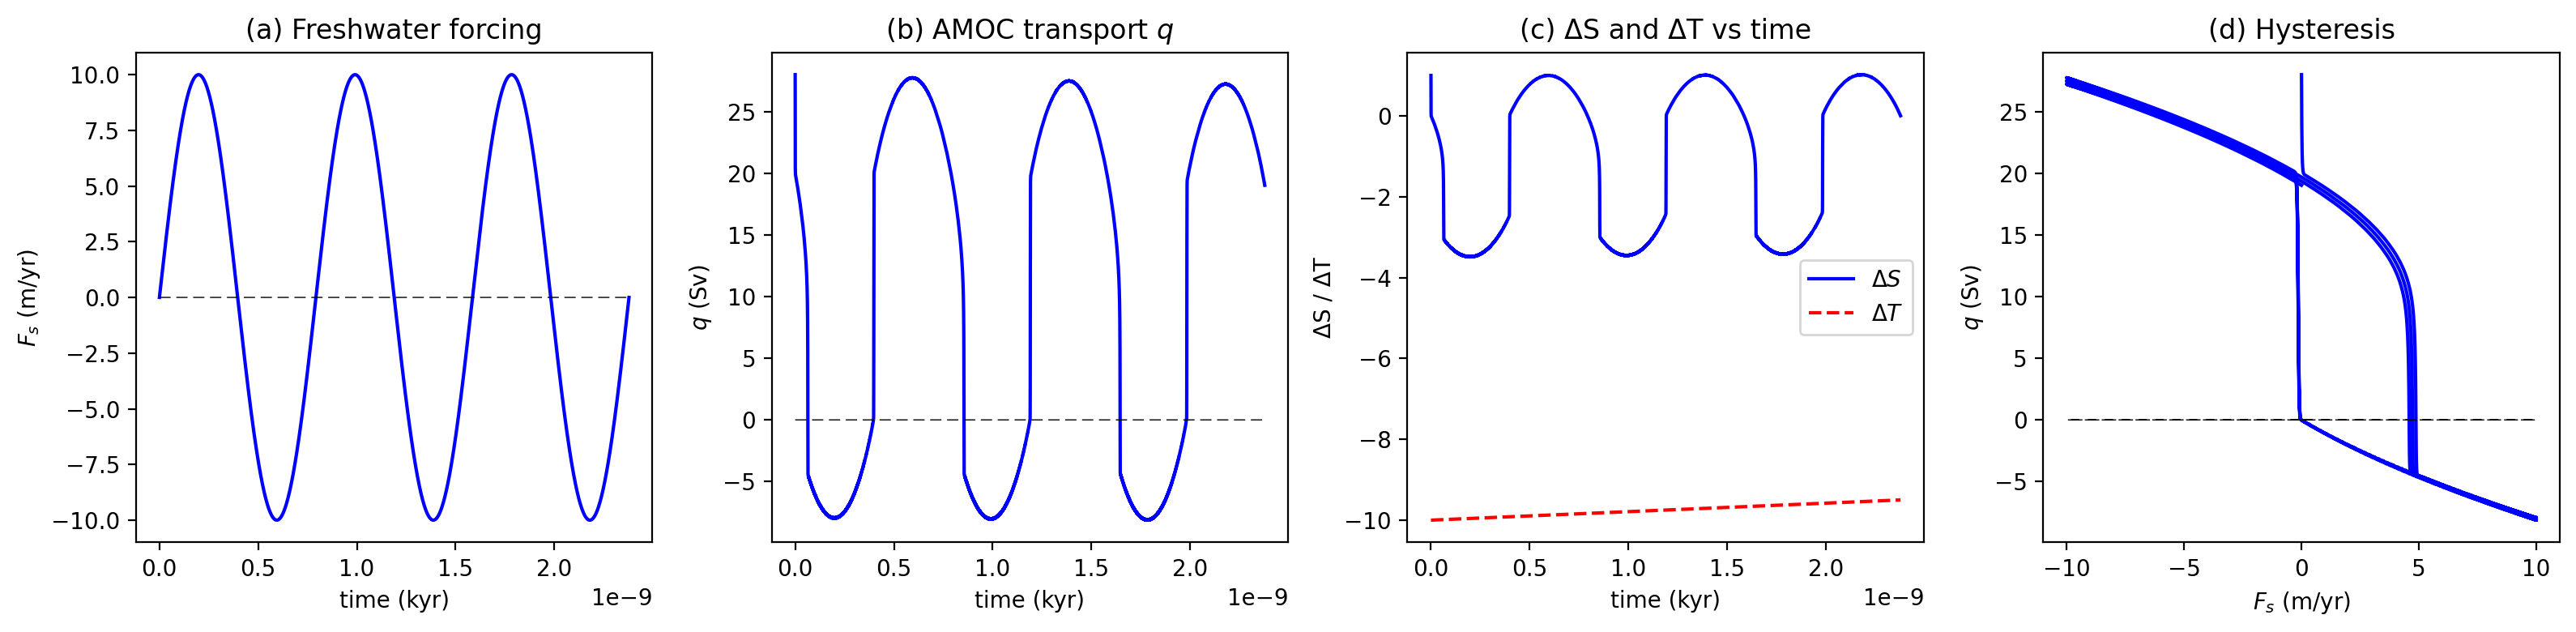

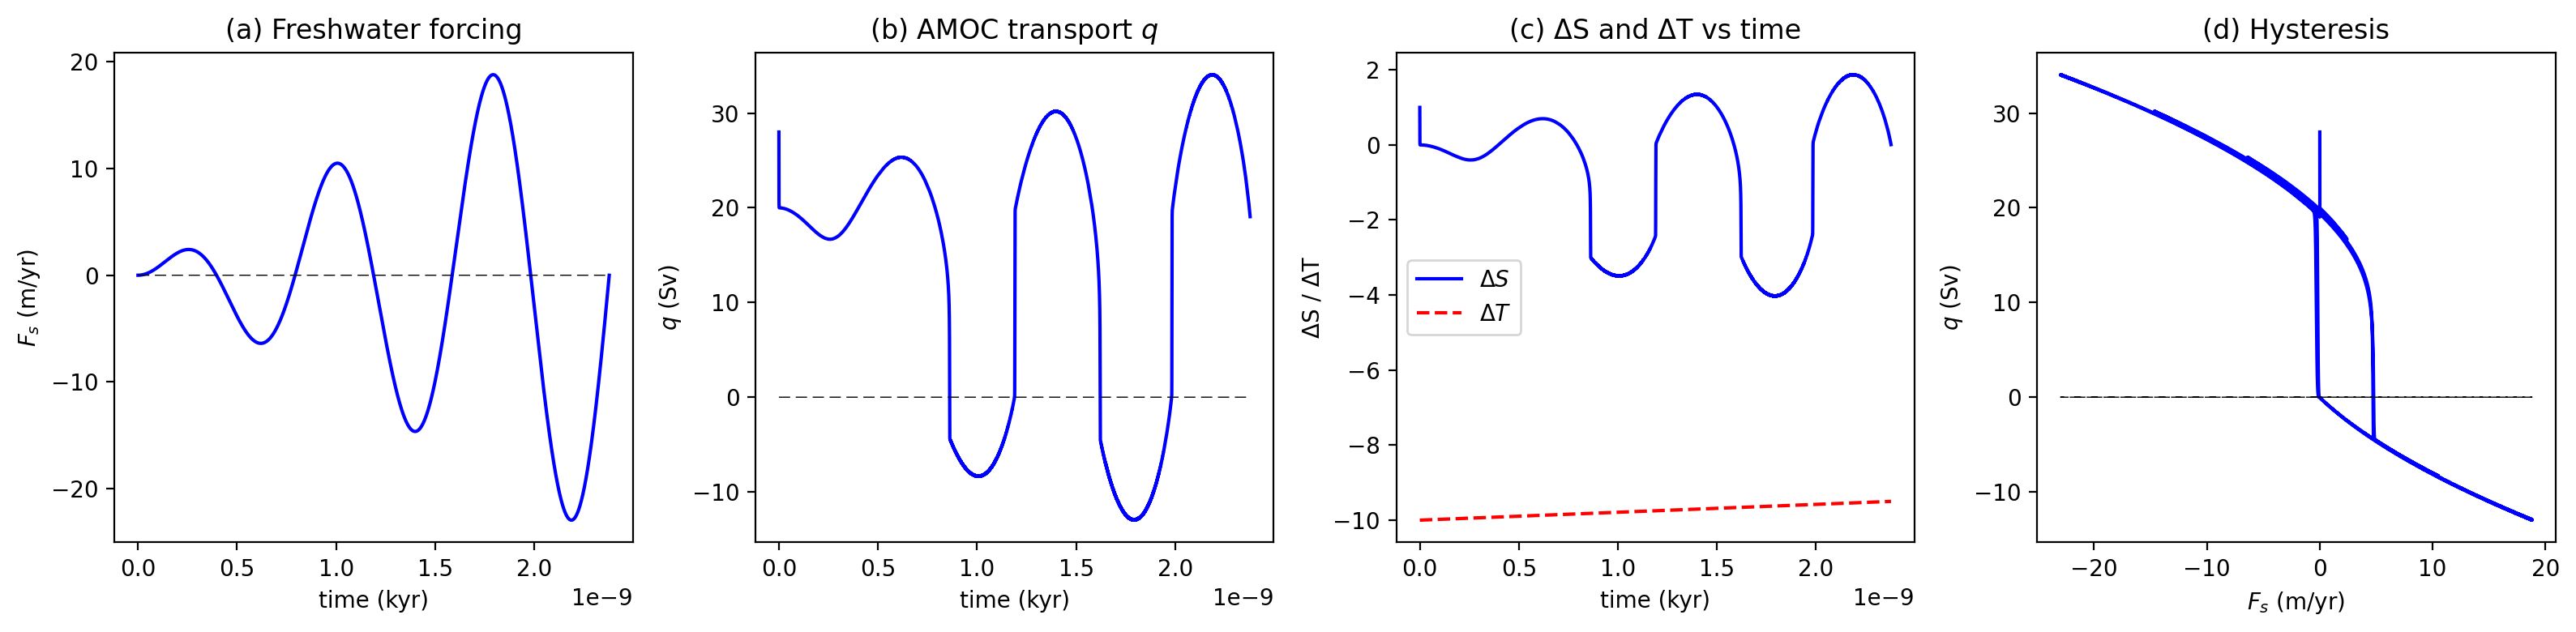

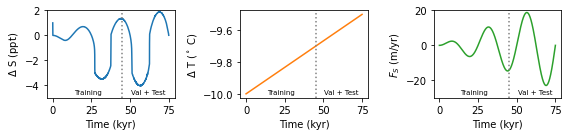

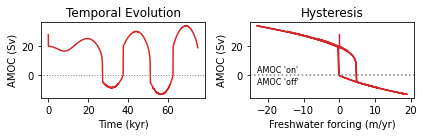

In [2]:
%run 00_generate_data.ipynb

# STATIONARY CASE

In [50]:
input_data, output_data, qplot = get_data("s")

In [51]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

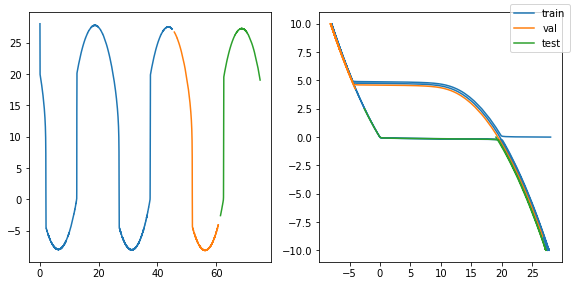

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [53]:
model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [26]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_scaled, y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/mlp/stationary/ensemble_member_'+str(i)+'.keras')

0
1
2
3
4
5
6
7
8
9
10
11


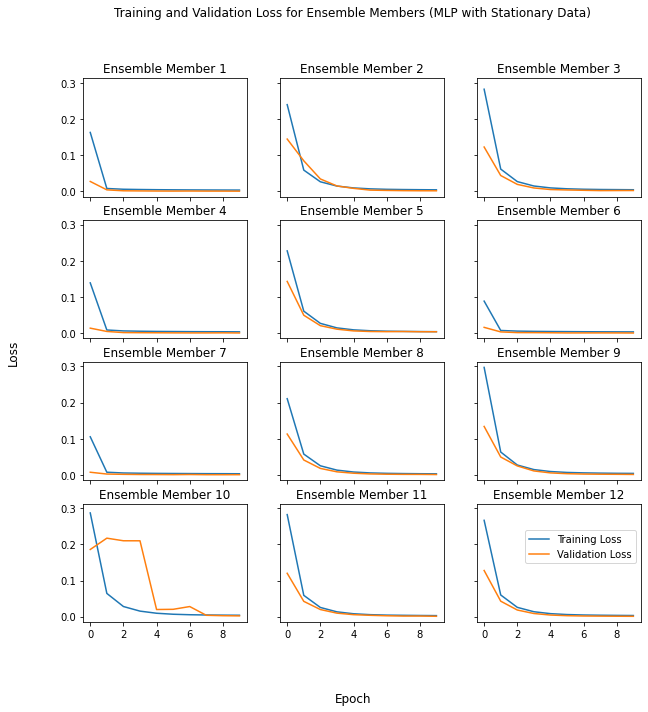

In [29]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (MLP with Stationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_mlp_s.pdf')

In [54]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_scaled.shape[0], 1))

for i in range(12):
    print(i)
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights('models/mlp/stationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, y_test)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_scaled)
    predicted_results_ensemble[i,...] = predicted

0
563/563 [==============================] - 1s 810us/step - loss: 0.0063 - accuracy: 0.9978
Test loss: 0.00634442875161767
Test accuracy: 0.9977787733078003
3125/3125 [==============================] - 2s 712us/step
1
563/563 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9461
Test loss: 0.10944761335849762
Test accuracy: 0.9460794925689697
3125/3125 [==============================] - 3s 927us/step
2
563/563 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 0.9976
Test loss: 0.009854043833911419
Test accuracy: 0.9975566267967224
3125/3125 [==============================] - 2s 674us/step
3
563/563 [==============================] - 1s 786us/step - loss: 0.0548 - accuracy: 0.9685
Test loss: 0.05479631945490837
Test accuracy: 0.9684584736824036
3125/3125 [==============================] - 2s 724us/step
4
563/563 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 0.9972
Test loss: 0.01602243073284626
Test accuracy

In [55]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_data)

In [56]:
len(false_indices[0])

99

In [17]:
test_indices = set(range(81992, 100000))
wrong_in_test = list(set(false_indices[0]) & test_indices)
np.save('incorrect_indices_mlp_s', np.array(wrong_in_test))

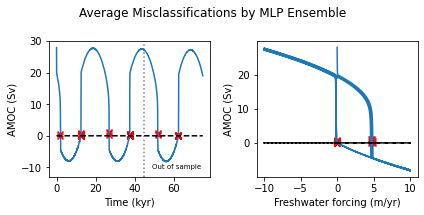

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
split_idx = 60033
split_time = input_data[split_idx, 0]
ax[0].plot(input_data[:, 0], qplot/Sv)
ax[0].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
fig.suptitle('Average Misclassifications by MLP Ensemble')
ax[0].scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('AMOC (Sv)')
ax[0].axvline(x=split_time, linestyle='dotted', color='grey');
ax[0].set_ylim(-13, 30)
ymin, ymax = ax[0].get_ylim();
yloc = ymin + 0.1 * (ymax - ymin);
ax[0].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
               "Out of sample", ha="center", va="top", fontsize=7, color="black")
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 0]), 'k--')
ax[1].scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax[1].set_xlabel('Freshwater forcing (m/yr)')
ax[1].set_ylabel('AMOC (Sv)')
fig.tight_layout()
fig.savefig('figures/training/preds_all_mlp_s.pdf')

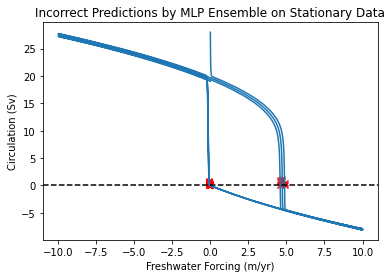

In [23]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Incorrect Predictions by MLP Ensemble on Stationary Data')
ax.scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_mlp_s_hysteresis.pdf')

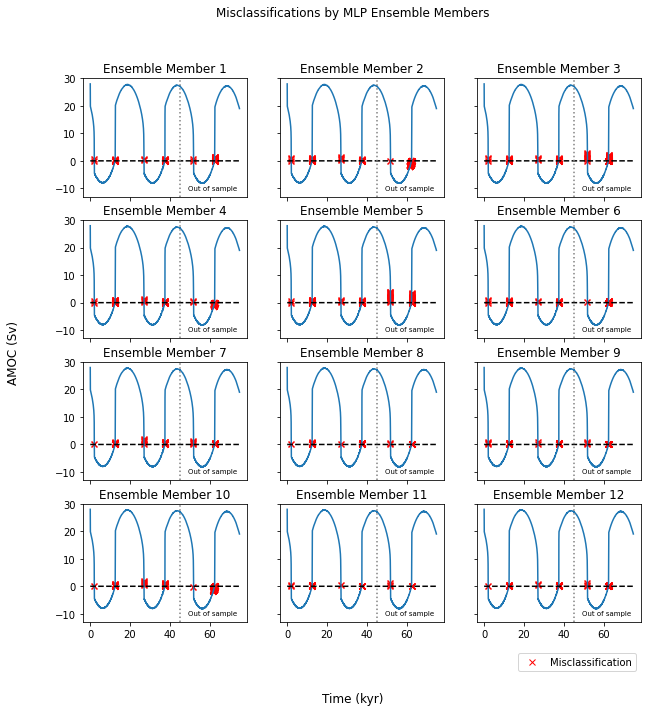

In [31]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by MLP Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
    ax[i].axvline(x=split_time, linestyle='dotted', color='grey');
    ax[i].set_ylim(-13, 30)
    ymin, ymax = ax[i].get_ylim();
    yloc = ymin + 0.1 * (ymax - ymin);
    ax[i].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
                   "Out of sample", ha="center", va="top", fontsize=7, color="black")
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_mlp_s_t.pdf')

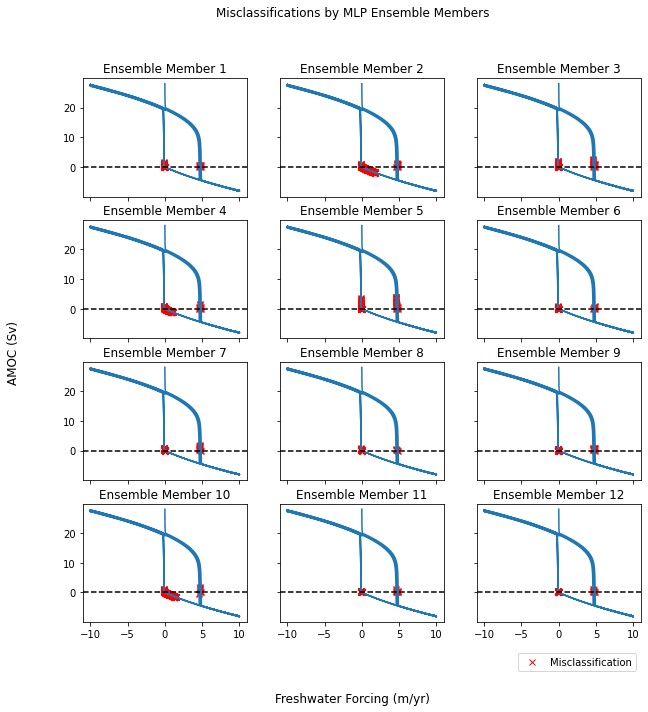

In [57]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by MLP Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_mlp_s_h.pdf')

# NONSTATIONARY CASE

In [33]:
input_data, output_data, qplot = get_data("ns")

In [34]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

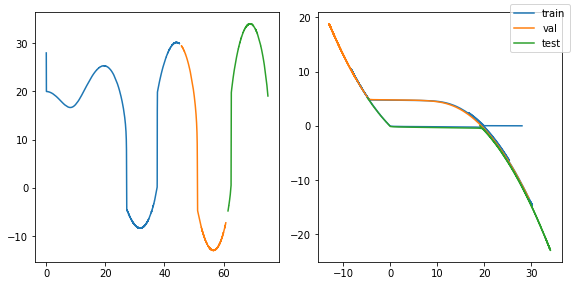

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X_train[:, 0], qplot[0:60032]/Sv);
ax[0].plot(X_val[:, 0], qplot[61024:81000]/Sv);
ax[0].plot(X_test[:, 0], qplot[81992:100000]/Sv);
ax[1].plot(qplot[0:60032]/Sv, input_data[:, 3][0:60032]/Fs_to_m_per_year, label='train');
ax[1].plot(qplot[61024:81000]/Sv, input_data[:,3][61024:81000]/Fs_to_m_per_year, label='val');
ax[1].plot(qplot[81992:100000]/Sv, input_data[:, 3][81992:100000]/Fs_to_m_per_year, label='test');
fig.legend();
fig.tight_layout()

In [36]:
model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
training_losses = np.zeros(12, dtype=np.ndarray)
validation_losses = np.zeros(12, dtype=np.ndarray)

In [55]:
# training the ensemble 
for i in range(12):
    print(i)
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_eval = model.fit(X_train_scaled, y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[es])#,
    training_losses[i] = model_eval.history['loss']
    validation_losses[i] = model_eval.history['val_loss']
    model.save('models/mlp/nonstationary/ensemble_member_'+str(i)+'.keras')

0
1
2
3
4
5
6
7
8
9
10
11


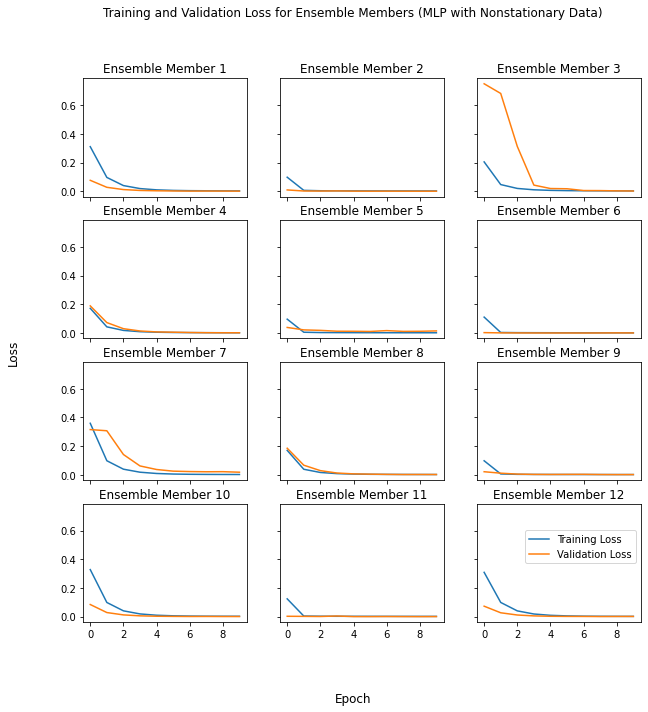

In [64]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10));
fig.supxlabel('Epoch');
fig.supylabel('Loss');
fig.suptitle('Training and Validation Loss for Ensemble Members (MLP with Nonstationary Data)');
ax = ax.flatten();
for i in range(12):
    ax[i].plot(training_losses[i], label='Training Loss')
    ax[i].plot(validation_losses[i], label='Validation Loss')
    ax[i].set_title('Ensemble Member ' + str(i+1))
fig.legend(
    labels=['Training Loss', 'Validation Loss'],
    loc='lower right',
    bbox_to_anchor=(0.9, 0.2) 
)
fig.savefig('figures/training/losses_mlp_ns.pdf')

In [37]:
accuracies = []
predicted_results_ensemble = np.nan * np.zeros((12, input_scaled.shape[0], 1))

for i in range(12):
    print(i)
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights('models/mlp/nonstationary/ensemble_member_'+str(i)+'.keras')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, y_test)
    accuracies.append(accuracy)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')
    predicted = model.predict(input_scaled)
    predicted_results_ensemble[i,...] = predicted

0
563/563 [==============================] - 1s 760us/step - loss: 0.0061 - accuracy: 0.9976
Test loss: 0.006129160523414612
Test accuracy: 0.9976121783256531
3125/3125 [==============================] - 2s 726us/step
1
563/563 [==============================] - 1s 759us/step - loss: 0.0343 - accuracy: 0.9813
Test loss: 0.03430714085698128
Test accuracy: 0.9812861084938049
3125/3125 [==============================] - 4s 1ms/step
2
563/563 [==============================] - 1s 767us/step - loss: 0.2943 - accuracy: 0.9320
Test loss: 0.294294536113739
Test accuracy: 0.932030200958252
3125/3125 [==============================] - 2s 682us/step
3
563/563 [==============================] - 1s 980us/step - loss: 0.1712 - accuracy: 0.9630
Test loss: 0.17124061286449432
Test accuracy: 0.9630164504051208
3125/3125 [==============================] - 3s 844us/step
4
563/563 [==============================] - 1s 795us/step - loss: 0.0150 - accuracy: 0.9967
Test loss: 0.01497375313192606
Test accurac

In [38]:
print('ensemble accuracy: ' + str(sum(accuracies)/12*100))

ensemble accuracy: 97.71259178717932


In [39]:
predicted_all = np.mean(predicted_results_ensemble, axis=0).reshape(-1)
predicted_labels = (predicted_all > 0.5).astype(int)
false_indices = np.where(predicted_labels != output_data)

In [34]:
test_indices = set(range(81992, 100000))
wrong_in_test = list(set(false_indices) & test_indices)
np.save('incorrect_indices_mlp_ns', np.array(wrong_in_test))

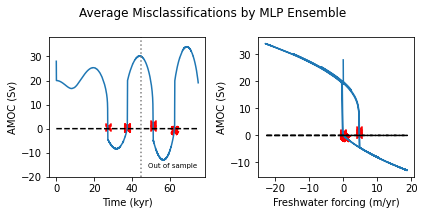

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
split_idx = 60033
split_time = input_data[split_idx, 0]
ax[0].plot(input_data[:, 0], qplot/Sv)
ax[0].plot(input_data[:, 0], np.zeros_like(input_data[:, 0]), 'k--')
fig.suptitle('Average Misclassifications by MLP Ensemble')
ax[0].scatter(input_data[false_indices, 0], qplot[false_indices]/Sv, marker='x', c='red')
ax[0].set_xlabel('Time (kyr)')
ax[0].set_ylabel('AMOC (Sv)')
ax[0].axvline(x=split_time, linestyle='dotted', color='grey');
ax[0].set_ylim(-20, 38)
ymin, ymax = ax[0].get_ylim();
yloc = ymin + 0.1 * (ymax - ymin);
ax[0].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
               "Out of sample", ha="center", va="top", fontsize=7, color="black")
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax[1].plot(input_data[:, 3]/Fs_to_m_per_year, np.zeros_like(input_data[:, 0]), 'k--')
ax[1].scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax[1].set_xlabel('Freshwater forcing (m/yr)')
ax[1].set_ylabel('AMOC (Sv)')
fig.tight_layout()
fig.savefig('figures/training/preds_all_mlp_ns.pdf')

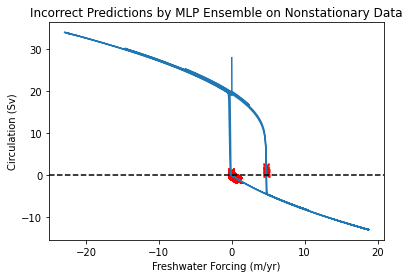

In [31]:
fig, ax = plt.subplots()
ax.plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv)
ax.axhline(0, color='black', linestyle='--');
ax.set_title('Incorrect Predictions by MLP Ensemble on Nonstationary Data')
ax.scatter(input_data[false_indices, 3]/Fs_to_m_per_year, qplot[false_indices]/Sv, marker='x', c='red')
ax.set_xlabel('Freshwater Forcing (m/yr)')
ax.set_ylabel('Circulation (Sv)')
fig.savefig('figures/training/preds_all_mlp_ns_hysteresis.pdf')

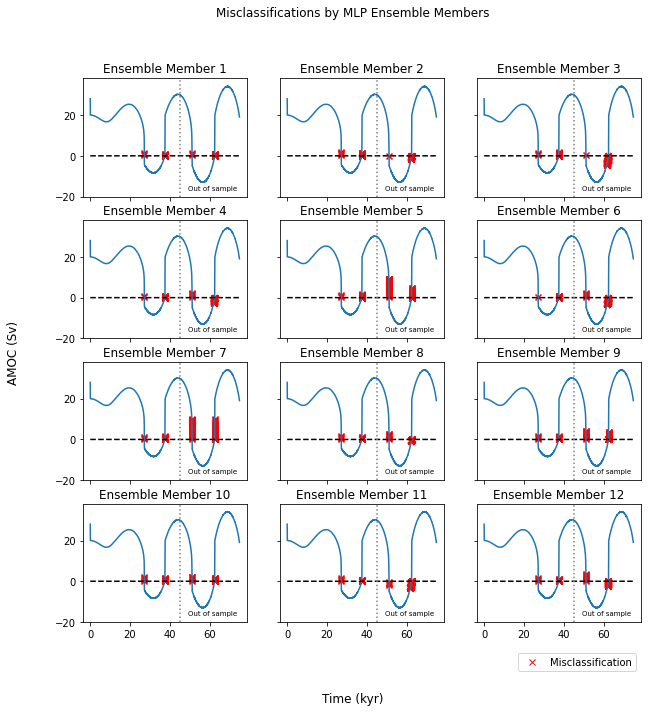

In [47]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by MLP Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 0], qplot/Sv);
    ax[i].plot(input_data[:, 0], input_data[:, 0]*0,'k--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 0][k] for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
    ax[i].axvline(x=split_time, linestyle='dotted', color='grey');
    ax[i].set_ylim(-20, 38)
    ymin, ymax = ax[i].get_ylim();
    yloc = ymin + 0.1 * (ymax - ymin);
    ax[i].text(split_time + (input_data[-1, 0]-split_time)/1.8, yloc, 
                   "Out of sample", ha="center", va="top", fontsize=7, color="black")
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_mlp_ns_t.pdf')

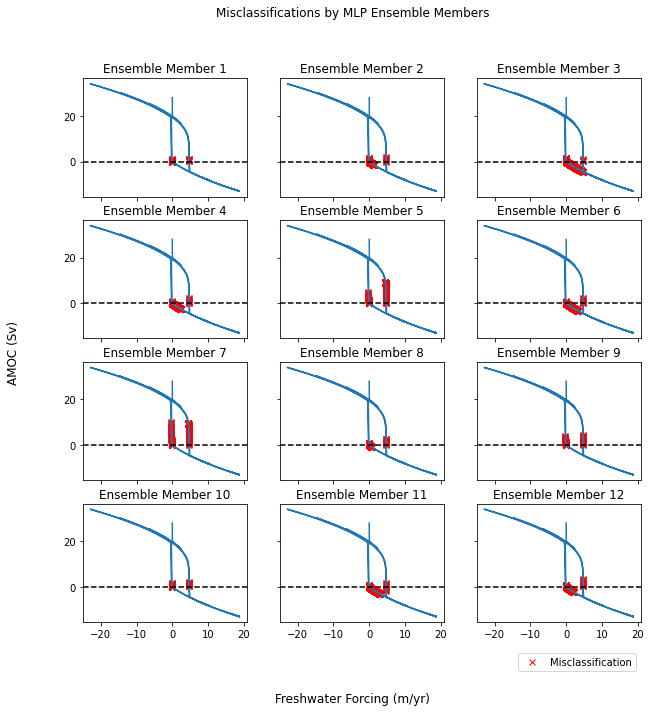

In [49]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Freshwater Forcing (m/yr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Misclassifications by MLP Ensemble Members')
ax = ax.flatten()
for i in range(12):
    ensemble_i_pred = (predicted_results_ensemble[i] > 0.5).astype(int)
    false_indices = []
    for j in range(len(ensemble_i_pred)):
        if ensemble_i_pred[j] != output_data[j]:
            false_indices.append(j)
    ax[i].plot(input_data[:, 3]/Fs_to_m_per_year, qplot/Sv);
    ax[i].axhline(0, color='black', linestyle='--');
    ax[i].set_title('Ensemble Member ' + str(i+1));
    ax[i].scatter([input_data[:, 3][k]/Fs_to_m_per_year for k in false_indices], [qplot[k]/Sv for k in false_indices], marker='x', c='red');
red_x = mlines.Line2D([], [], color='red', marker='x', linestyle='None', label='Misclassification')
fig.legend(handles=[red_x], loc='lower right', bbox_to_anchor=(0.9, 0.05))
fig.savefig('figures/training/preds_ensemble_mlp_ns_h.pdf')